In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import pysam
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from utils.util_lift_over import liftover

if not os.getcwd().endswith('cfdna_snv_benchmark'):
    os.chdir('../')
print('Current working directory: {}'.format(os.getcwd()))

Current working directory: /Users/hanae/Repositories/cfdna_snv_benchmark


In [2]:
target = 'noncoding'
if target == 'coding':
    cosmic_pd = pd.read_csv(os.path.join('data', 'extdata', 'CosmicMutantExport.tsv'), encoding='ISO-8859-1', sep='\t', memory_map=True)
else: # target == 'noncoding'
    cosmic_pd = pd.read_csv(os.path.join('data', 'extdata', 'CosmicNCV.tsv'), encoding='ISO-8859-1', sep='\t', memory_map=True)

print(cosmic_pd.shape)

(18788998, 28)


In [3]:
cosmic_pd.columns

Index(['Sample name', 'ID_SAMPLE', 'ID_tumour', 'Primary site',
       'Site subtype 1', 'Site subtype 2', 'Site subtype 3',
       'Primary histology', 'Histology subtype 1', 'Histology subtype 2',
       'Histology subtype 3', 'GENOMIC_MUTATION_ID', 'LEGACY_MUTATION_ID',
       'zygosity', 'GRCh', 'genome position', 'Mutation somatic status',
       'WT_SEQ', 'MUT_SEQ', 'FATHMM_MKL_NON_CODING_SCORE',
       'FATHMM_MKL_NON_CODING_GROUPS', 'FATHMM_MKL_CODING_SCORE',
       'FATHMM_MKL_CODING_GROUPS', 'Whole_Genome_Reseq', 'Whole_Exome',
       'ID_STUDY', 'PUBMED_PMID', 'HGVSG'],
      dtype='object')

## Columns for coding file
['Gene name', 'Accession Number', 'Gene CDS length', 'HGNC ID',
'Sample name', 'ID_sample', 'ID_tumour', 'Primary site',
'Site subtype 1', 'Site subtype 2', 'Site subtype 3',
'Primary histology', 'Histology subtype 1', 'Histology subtype 2',
'Histology subtype 3', 'Genome-wide screen', 'GENOMIC_MUTATION_ID',
'LEGACY_MUTATION_ID', 'MUTATION_ID', 'Mutation CDS', 'Mutation AA',
'Mutation Description', 'Mutation zygosity', 'LOH', 'GRCh',
'Mutation genome position', 'Mutation strand', 'Resistance Mutation',
'FATHMM prediction', 'FATHMM score', 'Mutation somatic status',
'Pubmed_PMID', 'ID_STUDY', 'Sample Type', 'Tumour origin', 'Age',
'HGVSP', 'HGVSC', 'HGVSG']
## Columns for noncoding file


## Primary sites
['breast' 'haematopoietic_and_lymphoid_tissue' 'lung' 'liver'
 'endometrium' 'upper_aerodigestive_tract' 'large_intestine' 'skin'
 'kidney' 'soft_tissue' 'ovary' 'central_nervous_system' 'biliary_tract'
 'stomach' 'oesophagus' 'prostate' 'urinary_tract' 'bone'
 'autonomic_ganglia' 'penis' 'uterine_adnexa' 'cervix' 'pancreas' 'NS'
 'testis' 'thyroid' 'pleura' 'placenta' 'meninges' 'small_intestine'
 'genital_tract' 'adrenal_gland' 'salivary_gland' 'thymus' 'peritoneum'
 'eye' 'parathyroid' 'pituitary'
 'gastrointestinal_tract_(site_indeterminate)'
 'female_genital_tract_(site_indeterminate)' 'vulva' 'fallopian_tube'
 'vagina' 'paratesticular_tissues' 'perineum' 'retroperitoneum'
 'pericardium' 'mediastinum' 'female_genitourinary_system']

In [4]:
cancer_type = 'CRC'
chrom = '22'

In [5]:
# cancer type selection
if cancer_type == 'CRC':
    if target == 'coding':
        cosmic_muts = cosmic_pd[(cosmic_pd['Primary site'] == 'large_intestine') & (cosmic_pd['Site subtype 1'] == 'colon') & (cosmic_pd['Tumour origin'] == 'primary')]
    else: # target == 'noncoding'
        cosmic_muts = cosmic_pd[(cosmic_pd['Primary site'] == 'large_intestine') & (cosmic_pd['Site subtype 1'] == 'colon')]

else:
    print('NEED TO INCLUDE THIS CANCER TYPE')
print(cosmic_muts.shape)

(297743, 28)


In [6]:
# remove nan positions in GRCh37
cosmic_muts = cosmic_muts[~cosmic_muts["GRCh"].isna()]
print(cosmic_muts.shape)

(297743, 28)


In [7]:
# annotate mutation type
cosmic_muts['type'] = np.nan
if target == 'coding':
    print(cosmic_muts['Mutation Description'].unique()) # SNV or INDEL
    cosmic_muts['type'][cosmic_muts['Mutation Description'].str.contains('Substitution') == True] = 'SNV'
    cosmic_muts['type'][cosmic_muts['Mutation Description'].str.contains('Insertion') == True] = 'INS'
    cosmic_muts['type'][cosmic_muts['Mutation Description'].str.contains('Deletion') == True] = 'DEL'
    cosmic_muts.dropna(subset=['type'], inplace=True)
else: # target == 'noncoding'
    cosmic_muts['type'][cosmic_muts['MUT_SEQ'].str.len()-cosmic_muts['WT_SEQ'].str.len() == 0] = 'SNV'
    cosmic_muts['type'][cosmic_muts['MUT_SEQ'].str.len()-cosmic_muts['WT_SEQ'].str.len() > 0] = 'INS'
    cosmic_muts['type'][cosmic_muts['MUT_SEQ'].str.len()-cosmic_muts['WT_SEQ'].str.len() < 0] = 'DEL'
    cosmic_muts = cosmic_muts[~cosmic_muts['type'].isna()]
print(cosmic_muts.shape)
cosmic_muts.head()

/Users/hanae/opt/anaconda3/envs/default/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/hanae/opt/anaconda3/envs/default/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/hanae/opt/anaconda3/envs/default/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas

(263106, 29)


,Sample name,ID_SAMPLE,ID_tumour,Primary site,Site subtype 1,Site subtype 2,Site subtype 3,Primary histology,Histology subtype 1,Histology subtype 2,...,FATHMM_MKL_NON_CODING_SCORE,FATHMM_MKL_NON_CODING_GROUPS,FATHMM_MKL_CODING_SCORE,FATHMM_MKL_CODING_GROUPS,Whole_Genome_Reseq,Whole_Exome,ID_STUDY,PUBMED_PMID,HGVSG,type
1,MSS3-a,2809968,2666630,large_intestine,colon,transverse,NS,adenoma,tubular,high_grade_dysplasia,...,0.90866,NaN,0.56856,NaN,n,y,NaN,26336987.0,3:g.49051329C>A,SNV
76,TCGA-AM-5821-01,1651151,1565938,large_intestine,colon,sigmoid,NS,carcinoma,adenocarcinoma,NS,...,0.40931,NaN,0.00684,NaN,n,y,376.0,NaN,16:g.81053830C>T,SNV
218,1517_CLM,2501001,2363352,large_intestine,colon,right,NS,carcinoma,adenocarcinoma,NS,...,0.71715,NaN,0.65593,NaN,n,y,NaN,26109429.0,17:g.45904542C>T,SNV
637,T473,2296250,2161853,large_intestine,colon,descending,NS,carcinoma,adenocarcinoma,NS,...,0.39984,NaN,0.24301,NaN,n,y,NaN,25344691.0,2:g.160053219C>T,SNV
676,T6,2411195,2274074,large_intestine,colon,NS,NS,carcinoma,adenocarcinoma,NS,...,0.06152,NaN,0.00313,NaN,n,y,NaN,26071483.0,6:g.150205612G>A,SNV


In [8]:
# encode mutation position
if target == 'coding':
    mutposname = 'Mutation genome position'
else: # target == 'noncoding'
    mutposname = 'genome position'
cosmic_muts['chrom'] = cosmic_muts[mutposname].str.split(':').str[0]
cosmic_muts['chrom'][cosmic_muts['chrom'] == 23] = 'X'
cosmic_muts['chrom'][cosmic_muts['chrom'] == 24] = 'Y'
cosmic_muts['startpos'] = cosmic_muts[mutposname].str.split(':').str[1].str.split('-').str[0]
cosmic_muts['endpos'] = cosmic_muts[mutposname].str.split(':').str[1].str.split('-').str[1]
cosmic_muts['chrom_pos'] = cosmic_muts['chrom'] + '_' + cosmic_muts['startpos'] + '_' + cosmic_muts['endpos']
cosmic_muts['startpos'] = cosmic_muts['startpos'].astype(int)
cosmic_muts['endpos'] = cosmic_muts['endpos'].astype(int)
cosmic_muts.dropna(subset=['chrom', 'startpos', 'endpos'], inplace=True)

/Users/hanae/opt/anaconda3/envs/default/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/hanae/opt/anaconda3/envs/default/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1.0 1.1347819336139673 1.0 1.0


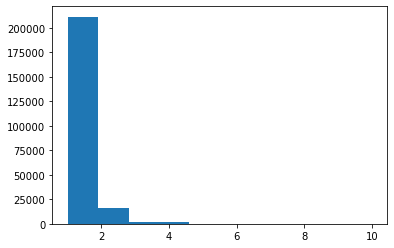

In [9]:
# get occurences
occurences = cosmic_muts[mutposname].value_counts().values
plt.hist(occurences[occurences <= 10])
print(np.quantile(occurences, 0.25), np.mean(occurences), np.median(occurences), np.quantile(occurences, 0.75))

In [10]:
# set threshold = at least 5 patients
threshold = 5
occ = cosmic_muts['chrom_pos'].value_counts() 
common_muts_occ = occ[occ >= threshold]
common_muts = list(common_muts_occ.index)
print(len(common_muts))

596


In [11]:
# select only single chromosome
cosmic_muts = cosmic_muts[cosmic_muts['chrom_pos'].isin(common_muts)]
print(cosmic_muts.shape)
cosmic_muts['chrom'].value_counts()

(6778, 33)


17    1852
5     1363
3      840
12     343
19     326
1      260
4      218
11     192
18     165
20     153
2      146
6      128
9      119
10     119
7      115
16      99
8       94
22      69
23      54
14      48
13      35
15      24
21      16
Name: chrom, dtype: int64

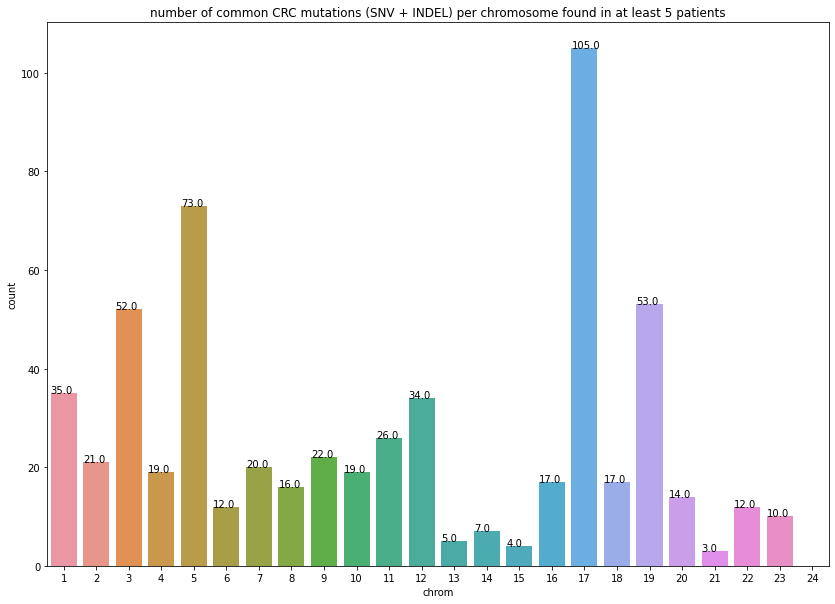

In [12]:
plt.figure(figsize=(14,10))
ax = sns.countplot(x='chrom', data=cosmic_muts[['chrom', 'startpos', 'endpos', 'chrom_pos']].drop_duplicates(), order=np.arange(1,25).astype(str))
plt.title('number of common {} mutations (SNV + INDEL) per chromosome found in at least {} patients'.format(cancer_type, threshold))
for p in ax.patches:
        ax.annotate('{}'.format(p.get_height()), (p.get_x(), p.get_height()))

In [13]:
cosmic_muts_chr = cosmic_muts[cosmic_muts['chrom'] == chrom]
print(cosmic_muts_chr.shape)

(69, 33)


In [14]:
if target == 'coding':
    # info about nomenclature http://varnomen.hgvs.org/recommendations/DNA/
    cosmic_muts_chr['ref'] = np.nan
    cosmic_muts_chr['alt'] = np.nan
    cosmic_muts_chr['ref'][cosmic_muts_chr['type'] == 'SNV'] = cosmic_muts_chr[cosmic_muts_chr['type'] == 'SNV']['Mutation CDS'].str.split('>').str[0].str[-1] 
    cosmic_muts_chr['alt'][cosmic_muts_chr['type'] == 'SNV'] = cosmic_muts_chr[cosmic_muts_chr['type'] == 'SNV']['Mutation CDS'].str.split('>').str[1]
    cosmic_muts_chr['alt'][cosmic_muts_chr['type'] == 'INS'] = cosmic_muts_chr[cosmic_muts_chr['type'] == 'INS']['Mutation CDS'].str.split('ins').str[1] 
    for ri, row in cosmic_muts_chr.iterrows():
        if (row['type'] == 'INS') and (row['Mutation CDS'].endswith('dup')):
            chromrow, startpos, endpos = row['chrom_pos'].split('_')
            if chromrow.startswith('chr'):
                chromrow = chromrow[3:]
            startpos, endpos = int(startpos), int(endpos)
            fasta = pysam.FastaFile(os.path.join('data', 'GRCh37', 'GRCh37.fa'))
            ref_seq = fasta.fetch(chromrow, startpos-1, startpos)
            fasta.close()
            cosmic_muts_chr.at[ri, 'ref'] = ref_seq
            cosmic_muts_chr.at[ri, 'alt'] = ref_seq
    # needs shift in deletions for bamsurgeon to indicate length of deletion
    cosmic_muts_chr.loc[cosmic_muts_chr['type'] == 'DEL', 'endpos'] += 1 #cosmic_muts_chr[cosmic_muts_chr['type'] == 'DEL', 'endpos'] + 1
else: # target noncoding
    cosmic_muts_chr['ref'] = cosmic_muts_chr['WT_SEQ']
    cosmic_muts_chr['alt'] = cosmic_muts_chr['MUT_SEQ']
cosmic_muts_chr.head()

/Users/hanae/opt/anaconda3/envs/default/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/hanae/opt/anaconda3/envs/default/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Sample name,ID_SAMPLE,ID_tumour,Primary site,Site subtype 1,Site subtype 2,Site subtype 3,Primary histology,Histology subtype 1,Histology subtype 2,...,ID_STUDY,PUBMED_PMID,HGVSG,type,chrom,startpos,endpos,chrom_pos,ref,alt
128804,L1,2588720,2449851,large_intestine,colon,NS,NS,carcinoma,adenocarcinoma,NS,...,NaN,27023146.0,22:g.23655130A>T,SNV,22,23655130,23655130,22_23655130_23655130,A,T
353100,PCRC13_3A,2873949,2728822,large_intestine,colon,ascending,NS,carcinoma,adenocarcinoma,NS,...,NaN,30038269.0,22:g.20761324C>T,SNV,22,20761324,20761324,22_20761324_20761324,C,T
572688,PCRC13_1A,2873947,2728822,large_intestine,colon,ascending,NS,carcinoma,adenocarcinoma,NS,...,NaN,30038269.0,22:g.20761324C>T,SNV,22,20761324,20761324,22_20761324_20761324,C,T
883800,TCGA-F4-6463-01,1651301,1566088,large_intestine,colon,transverse,NS,carcinoma,adenocarcinoma,NS,...,376.0,NaN,22:g.20780097G>C,SNV,22,20780097,20780097,22_20780097_20780097,G,C
898004,P2-1,2588714,2449849,large_intestine,colon,NS,NS,carcinoma,adenocarcinoma,NS,...,NaN,27023146.0,22:g.23654017G>A,SNV,22,23654017,23654017,22_23654017_23654017,G,A


In [15]:
cosmic_bed_chr = cosmic_muts_chr[['chrom', 'startpos', 'endpos', 'alt', 'type']].reset_index(drop=True)
cosmic_bed_chr.drop_duplicates(inplace=True, ignore_index=True)
print(cosmic_bed_chr.shape)
print(cosmic_bed_chr[cosmic_bed_chr['type'] == 'INS'].head())
print(cosmic_bed_chr[cosmic_bed_chr['type'] == 'DEL'].head())
cosmic_bed_chr.head()

(12, 5)
Empty DataFrame
Columns: [chrom, startpos, endpos, alt, type]
Index: []
Empty DataFrame
Columns: [chrom, startpos, endpos, alt, type]
Index: []


,chrom,startpos,endpos,alt,type
0,22,23655130,23655130,T,SNV
1,22,20761324,20761324,T,SNV
2,22,20780097,20780097,C,SNV
3,22,23654017,23654017,A,SNV
4,22,50636872,50636872,A,SNV


In [16]:
# check for errors
# SNV
print(sum(cosmic_bed_chr[cosmic_bed_chr['type'] == 'SNV']['endpos'] != cosmic_bed_chr[cosmic_bed_chr['type'] == 'SNV']['startpos']))
# INS
print(sum(cosmic_bed_chr[cosmic_bed_chr['type'] == 'INS']['endpos'] - cosmic_bed_chr[cosmic_bed_chr['type'] == 'INS']['startpos'] != cosmic_bed_chr[cosmic_bed_chr['type'] == 'INS']['alt'].str.len()))
print(sum(cosmic_bed_chr[cosmic_bed_chr['type'] == 'INS']['endpos'] - cosmic_bed_chr[cosmic_bed_chr['type'] == 'INS']['startpos'] <= 0))
# DEL
print(sum(cosmic_bed_chr[cosmic_bed_chr['type'] == 'DEL']['startpos'] - cosmic_bed_chr[cosmic_bed_chr['type'] == 'DEL']['endpos'] >= 0))

0
0
0
0


22    12
Name: chrom, dtype: int64


ValueError: min() arg is an empty sequence

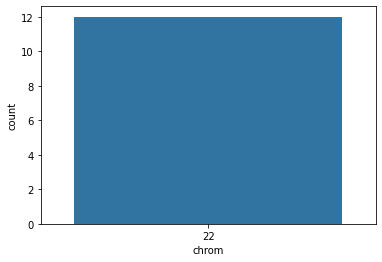

<Figure size 432x288 with 0 Axes>

In [18]:
sns.countplot(x='chrom', data=cosmic_bed_chr[cosmic_bed_chr['type'] == 'SNV'])
print(cosmic_bed_chr[cosmic_bed_chr['type'] == 'SNV']['chrom'].value_counts().sort_index())
plt.figure()
sns.countplot(x='chrom', data=cosmic_bed_chr[(cosmic_bed_chr['type'] == 'INS') | (cosmic_bed_chr['type'] == 'DEL')])
print(cosmic_bed_chr[(cosmic_bed_chr['type'] == 'INS') | (cosmic_bed_chr['type'] == 'DEL')]['chrom'].value_counts().sort_index())

# Save for SNV and INDEL bedfile for bamsurgeon

In [19]:
### /!\ 1-based index for SNV bamsurgeon
cosmic_bed_chr_snv = cosmic_bed_chr[cosmic_bed_chr['type'] == 'SNV'].drop('type', axis=1)
cosmic_bed_chr_snv.insert(loc = 3, column = 'vaf', value = 1)  # Insert default VAF column
cosmic_bed_chr_snv

,chrom,startpos,endpos,vaf,alt
0,22,23655130,23655130,1,T
1,22,20761324,20761324,1,T
2,22,20780097,20780097,1,C
3,22,23654017,23654017,1,A
4,22,50636872,50636872,1,A
5,22,24121378,24121378,1,T
6,22,38477342,38477342,1,A
7,22,19968971,19968971,1,A
8,22,23632513,23632513,1,G
9,22,43289473,43289473,1,A


In [20]:
### /!\ 0-based index for INDEL bamsurgeon
cosmic_bed_chr_indel = cosmic_bed_chr[(cosmic_bed_chr['type'] == 'INS') | (cosmic_bed_chr['type'] == 'DEL')].drop('type', axis=1)
cosmic_bed_chr_indel.insert(loc = 3, column = 'vaf', value = 1)  # Insert default VAF column
cosmic_bed_chr_indel['startpos'] -= 1
cosmic_bed_chr_indel['endpos'] -= 1
cosmic_bed_chr_indel

,chrom,startpos,endpos,vaf,alt


In [ ]:
# save bed files 
cosmic_bed_chr_snv.to_csv('data/spikein/spikein_chr'+chrom+'/common_cancer_mutations/'+cancer_type+'_chr'+chrom+'_SNV_tf1.bed', sep='\t', header=False, index=False)
cosmic_bed_chr_indel.to_csv('data/spikein/spikein_chr'+chrom+'/common_cancer_mutations/'+cancer_type+'_chr'+chrom+'_INDEL_tf1.bed', sep='\t', header=False, index=False)